In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.platform.automl_v4 import AutoML_v4

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

import warnings
warnings.simplefilter("ignore")

import pickle as pkl

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [ ]:
data_dir = "../data/raw"
raw_df = pd.read_csv(f"{data_dir}/spectra.csv")
label_df = pd.read_csv(f"{data_dir}/label.csv")

raw_df.shape, label_df.shape

In [ ]:
label_df = label_df.drop(columns = 'lot_name')

X_train, y_train = preprocess(raw_df, label_df,  wavelengths=WAVELENGTHS_3NM_V1)

X_train.shape, y_train.shape

# Classify

In [3]:
encoder = LabelEncoder()
y_train_encoded = pd.Series(
    encoder.fit_transform(y_train),
    index = y_train.index
)

pkl.dump(encoder, open("../model/encoder.pkl", "wb"))

X_train.shape, y_train_encoded.shape

(30, 4) (6, 2)


((30, 191), (30,))

In [3]:
trainer = AutoML_v4(task_type = "classify")
trainer.fit(X_train, y_train_encoded)
pkl.dump(trainer, open(
    "../model/trainer.pkl", "wb"
))

100%|██████████| 200/200 [00:20<00:00,  9.67trial/s, best loss: 0.0]             


AutoML v4: SNV-Scaler-SVC

In [15]:
grouped_X = X_train.groupby(X_train.index).mean()
grouped_y = y_train_encoded.groupby(y_train_encoded.index).mean()

kfold = StratifiedGroupKFold(n_splits = 3)
cv_pred = cross_val_predict(
    trainer.get_pipeline(),
    grouped_X,
    grouped_y,
    cv = kfold,
    groups = grouped_X.index
)

train_pred = trainer.predict(grouped_X)

In [ ]:
cnfm_settings = {
    "cmap": "Blues",
    "cbar": None,
    "annot": True,
    "fmt": ".0f",
    "xticklabels": encoder.classes_,
    "yticklabels": encoder.classes_,
}

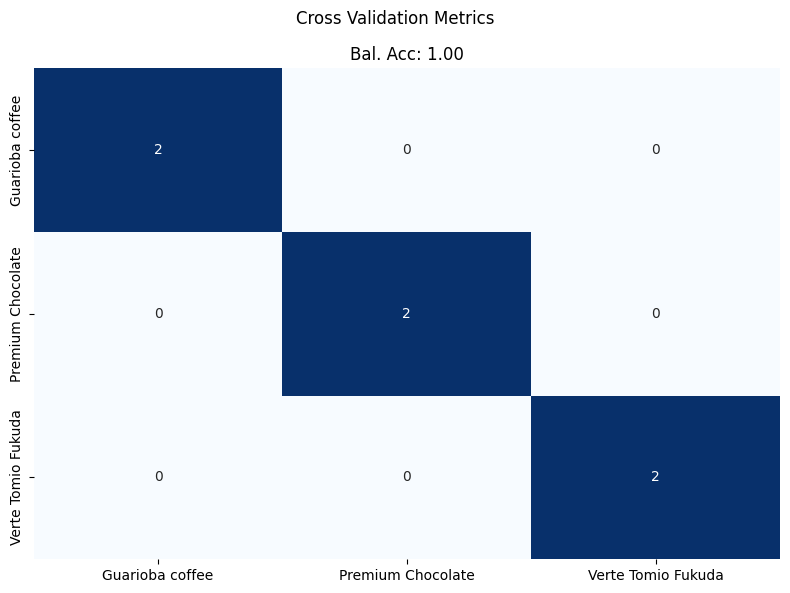

In [17]:
cnfm = confusion_matrix(grouped_y, cv_pred)
bal_acc = balanced_accuracy_score(grouped_y, cv_pred)

fig = plt.figure(figsize = (8, 6))
fig.suptitle("Cross Validation Metrics")
ax = fig.add_subplot(111)

ax.set_title(f"Bal. Acc: {bal_acc:.2f}")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

sns.heatmap(
    cnfm,
    ax = ax,
    **cnfm_settings
)

plt.tight_layout()
plt.show()

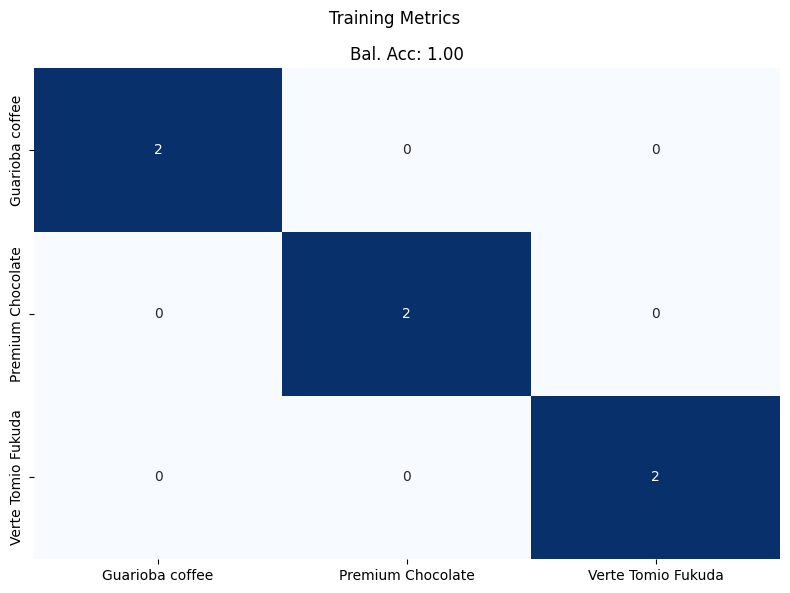

In [18]:
cnfm = confusion_matrix(grouped_y, train_pred)
bal_acc = balanced_accuracy_score(grouped_y, train_pred)

fig = plt.figure(figsize = (8, 6))
fig.suptitle("Training Metrics")
ax = fig.add_subplot(111)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.set_title(f"Bal. Acc: {bal_acc:.2f}")
sns.heatmap(
    cnfm,
    ax = ax,
    **cnfm_settings
)

plt.tight_layout()
plt.show()

In [24]:
decoded_cnfm = pd.DataFrame(
    confusion_matrix(grouped_y, cv_pred),
    index = encoder.classes_,
    columns = encoder.classes_
)

decoded_cnfm.to_csv("../model/cv_cnfm.csv")
decoded_cnfm

,Guarioba coffee,Premium Chocolate,Verte Tomio Fukuda
Guarioba coffee,2,0,0
Premium Chocolate,0,2,0
Verte Tomio Fukuda,0,0,2
